# Homogeninization of Creative Ideation

In [ ]:
#!pip install pingouin
import mesa
import random
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pingouin as pg
from collections import Counter, defaultdict


## Human Agent Class

This code defines a 'HumanAgent' class, the agent simulates a human actor who genrates ideas.

### Initialization (init)
When a HumanAgent is created, it's given a unique_id, a reference to the model it belongs to, and a group it's assigned to (Control Group or intervention Group).

Each human agent also has an empty set called memory, which will store the ideas it has previously generated.

### Idea Creation (create_ideas)
This is where the human agent generates new ideas, based on a specified number (num_ideas_to_create) and a general idea_pool of available ideas. The process of generating ideas differs based on whether the agent belongs to the "intervention" group or not:

If the agent is in the "intervention" group:

50% from AI suggestions: The agent requests 50% of its target number of ideas from the model's ai_agent. These AI-proposed ideas are added to the newly_generated_ideas set.

30% from memory: The agent then attempts to recall 30% of its ideas from its own memory. If its memory is not empty, it randomly selects ideas from it and adds them to the newly_generated_ideas set.

20% new from pool: The remaining ideas needed (to reach num_ideas_to_create) are generated as completely new ideas from the idea_pool. Crucially, these new ideas must not already be in the agent's memory or in the eternal_memory of the AI agent.

If the agent is in the control group:

30% from memory: The agent generates 30% of its ideas by recalling them from its memory, similar to the "intervention" group.

70% new from pool: The remaining 70% of ideas are generated as new ideas from the idea_pool. These new ideas must not already be in the agent's memory.

Finally, regardless of the group, all newly_generated_ideas are added to the agent's memory for future recall, and the set of these newly generated ideas is returned. 

In [ ]:
class HumanAgent(mesa.Agent):
    """
    An agent that represents a human actor generating ideas.
    """
    def __init__(self, unique_id, model, group="intervention"):
        super().__init__(model)
        self.memory = set()
        self.unique_id = unique_id
        self.group = group

    
    def create_ideas(self, num_ideas_to_create, idea_pool):
        """
        Human agent generates a specified number of ideas.
        50% from AI suggestions (if available), 50% self-created.
        Of self-created: 30% from memory, 70% new from pool.
        """
        newly_generated_ideas = set()

        if self.group == "intervention":
            # 50% from AI suggestions (if available)
            num_from_ai = int(num_ideas_to_create * 0.5)
            ai_suggestions = self.model.ai_agent.propose_ideas(num_from_ai)
            #max_ai_ideas = self.model.ai_agent.propose_ideas(num_ideas_to_create)
            newly_generated_ideas.update(ai_suggestions)

        # 15% from memory (30% of 50% = 15%)
            num_from_memory = int(num_ideas_to_create * 0.15)
            if self.memory:
                ideas_from_memory = random.sample(list(self.memory), min(num_from_memory, len(self.memory)))
                newly_generated_ideas.update(ideas_from_memory)

        # 35% new from pool (not in memory or AI)
            num_new = num_ideas_to_create - len(newly_generated_ideas)
            forbidden = self.memory.union(set(ai_suggestions))
            new_ideas = list(idea_pool - forbidden - newly_generated_ideas)
            if new_ideas:
                newly_generated_ideas.update(random.sample(new_ideas, min(num_new, len(new_ideas))))
            
        # if more ideas are needed due to insufficient memory size
        #    remaining_needed = num_ideas_to_create - len(newly_generated_ideas)
        #    if remaining_needed > 0:
        #        fallback_list = [idea for idea in max_ai_ideas[num_from_ai:] if idea not in newly_generated_ideas]
        #        newly_generated_ideas.update(fallback_list[:remaining_needed])
        
        
        #self.memory.update(newly_generated_ideas) # Add newly generated ideas to memory
        #return newly_generated_ideas
        else:
            # 30% from memory
            num_from_memory = int(num_ideas_to_create * 0.3)
            if self.memory:
                ideas_from_memory = random.sample(list(self.memory), min(num_from_memory, len(self.memory)))
                newly_generated_ideas.update(ideas_from_memory)

            # 70% new from pool (not in memory)
            num_new = num_ideas_to_create - len(newly_generated_ideas)
            new_ideas = list(idea_pool - self.memory - newly_generated_ideas)
            if new_ideas:
                newly_generated_ideas.update(random.sample(new_ideas, min(num_new, len(new_ideas))))

        #self.memory.update(newly_generated_ideas)
        self.memory = newly_generated_ideas
        return newly_generated_ideas

    #def step(self):
    #    pass

### AIAgent Class

This pice code defines an `AIAgent` class. This agent simulates an AI that has a perfect, "eternal" memory of ideas and can propose them based on how frequently they've been seen.

#### Initialization (`__init__`)

  * When an `AIAgent` is created, it's given a `unique_id` and a reference to the `model` it belongs to.
  * The key feature of this AI agent is its `eternal_memory`, which is a dictionary. This dictionary will store ideas as keys and their frequency (how many times they've been encountered) as values.

#### Receiving Ideas (`receive_ideas`)

  * The `receive_ideas` method allows the AI agent to accept a collection of `ideas`.
  * For each idea it receives, the AI updates its `eternal_memory`. If an idea is already in its memory, its frequency count is incremented. If it's a new idea, it's added to the memory with an initial frequency of 1. This ensures the AI always remembers every idea it's ever received and how often it's seen each one.

#### Proposing Ideas (`propose_ideas`)

  * The `propose_ideas` method enables the AI to suggest a specified number of ideas (`num_ideas_to_propose`) from its `eternal_memory`.
  * If the `eternal_memory` is empty, the AI proposes no ideas.
  * Otherwise, the AI sorts all the ideas in its memory based on their **frequency** in descending order (most frequent first).
  * It then selects the top `num_ideas_to_propose` ideas from this sorted list and returns them as a set. This simulates the AI suggesting the ideas it has "learned" or encountered the most.

In [ ]:
class AIAgent(mesa.Agent):
    """
    An agent that represents an AI with no memory loss of ideas.
    """
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.eternal_memory = {}
        self.unique_id = unique_id

    def receive_ideas(self, ideas):
        """
        AI receives ideas and updates its eternal memory with their frequency.
        """
        for idea in ideas:
            self.eternal_memory[idea] = self.eternal_memory.get(idea, 0) + 1

    def propose_ideas(self, num_ideas_to_propose):
        """
        AI proposes ideas from its memory based on frequency.
        Simplified: top N most frequently submitted ideas.
        """
        if not self.eternal_memory:
            return set()

        # Sort ideas by frequency in descending order
        sorted_ideas = sorted(self.eternal_memory.items(), key=lambda item: item[1], reverse=True)
        
        # Take the top N ideas
        proposed_ideas = set()
        for idea, _ in sorted_ideas:
            proposed_ideas.add(idea)
            if len(proposed_ideas) >= num_ideas_to_propose:
                break
        return proposed_ideas

### HomogenizationModel Class


#### Initialization (`__init__`)

  * **Model Parameters:** 
      * `num_human_agents`: Total number of human agents in the simulation (default: 26).
      * `total_idea_pool_size`: The total number of unique ideas available in the system (default: 250).
      * `initial_ideas_per_actor`: Number of ideas an a gent can set during the initial step (default: (13.12, 4.29)).
      * `min_ideas`, `max_ideas`: Bounds for the number of ideas an agent can generate (default: 4, 27).
      * `current_step`: Tracks the current simulation step, initialized to 0.
  * **Idea Pool:** A `set` named `idea_pool` is created, containing all possible unique ideas (e.g., "idea\_0", "idea\_1", etc.).
  * **Agent Management:**
      * `all_model_agents`: A list to store all agents in the model (AI and Human).
      * **AI Agent Creation:** An `AIAgent` is instantiated and added to `all_model_agents`.
      * **Human Agent Creation:** `num_human_agents` are created. They are divided into two equal groups: "intervention" and "control". Half of the agents are assigned to the "intervention" group and the other half to the "control" group. Each `HumanAgent` is then added to `all_model_agents`.
  * **Data Collection (`mesa.DataCollector`):**
      * The `DataCollector` is set up to record specific metrics during the simulation:
          * **Model Reporters:**
              * `InterventionHomogenization`: Captures the homogenization percentage for the "intervention" group at each step.
              * `ControlHomogenization`: Captures the homogenization percentage for the "control" group at each step.
          * **Agent Reporters:**
              * `MemorySize`: For each `HumanAgent`, it records the current size of their `memory` set.
  * `running`: A boolean flag, initially `True`, which controls whether the simulation continues.
  * **Initial Idea Generation:** The `initial_idea_generation()` method is called immediately to set up the initial state of the human agents' memories.

#### Initial Idea Generation (`initial_idea_generation`)

  * This method handles the very first step (Step 0) where human agents acquire their initial set of ideas.
  * For each `HumanAgent`, a random number of ideas is determined by `initial_ideas_per_actor`, clamped between `min_ideas` and `max_ideas`.
  * These initial ideas are randomly selected from the `idea_pool` and added to each agent's `memory`.
  * All ideas generated across all human agents during this initial phase are collected and then passed to the `ai_agent` using its `receive_ideas` method, populating the AI's `eternal_memory` at the start.
  * Prints the total unique ideas and AI memory size after this step.

#### Calculate Group Homogenization (`calculate_group_homogenization`)

  * This method calculates a "homogenization" metric for both the "intervention" and "control" groups.
  * **Definition of Homogenization:** 
    - It's defined as $100 \\times (1 - \\{diversity})$,
   where diversity is the ratio of unique ideas within a group to the total `total_idea_pool_size`. A higher homogenization percentage means fewer unique ideas are present within the group relative to the total possible ideas, indicating less diversity and more shared ideas.
  * It iterates through all human agents, collecting all unique ideas held by agents in the "intervention" group and separately for the "control" group.
  * It then computes and returns the homogenization percentage for each group.

#### Get All Human Ideas (`get_all_human_ideas`)

  * A method that gathers all unique ideas present in the memories of *all* human agents combined.

#### Step (`step`)

  * This method represents one simulation round.
  * It increments the `current_step` counter.
  * It clears the `all_ideas_generated_in_round` set from the previous round.
  * **Human Agent Activation:**
      * It shuffles the list of human agents to ensure a random order of activation in each step.
      * For each human agent, it determines a random number of ideas to generate for the current step.
      * Each human agent then calls its `create_ideas` method to generate these ideas, which are added to a `ideas_this_round` set.
  * **AI Learning:** All ideas generated by human agents in this round (`ideas_this_round`) are then passed to the `ai_agent` using `receive_ideas`, allowing the AI to update its `eternal_memory`.
  * **Data Collection:** The `datacollector` is used to record the specified model and agent metrics for the current step.
  * **Progress Output:** Prints information about the current step, including the number of unique ideas generated, the AI's memory size, and the homogenization percentages for both groups.
  * **Convergence Check:** It checks if the size of the AI's `eternal_memory` has remained unchanged from the previous step. If so, it prints "Convergence reached." and sets `self.running` to `False`, effectively stopping the simulation.
  * **Memory Logging:** It calculates and logs the average memory size for human agents in both the "intervention" and "control" groups, storing this data in `self.group_memory_log`. It also logs the size of the AI's memory in `self.ai_memory_trace`.

In [ ]:
class HomogenizationModel(mesa.Model):
    """
    Simulating idea generation with human actors and an AI.
    Manually manages agent activation order.
    """
    def __init__(self, num_human_agents=52, total_idea_pool_size=250, initial_ideas_per_actor=(13.12, 4.29), min_ideas=4, max_ideas=27):
        super().__init__()
        self._agents = {}
        self.num_human_agents = num_human_agents
        self.total_idea_pool_size = total_idea_pool_size
        self.initial_ideas_per_actor = initial_ideas_per_actor
        self.min_ideas = min_ideas
        self.max_ideas = max_ideas
        self.current_step = 0

        self.idea_pool = set([f"idea_{i}" for i in range(total_idea_pool_size)])
        self.all_ideas_generated_in_round = set()

        self.all_model_agents = []

        # Create AI Agent
        self.ai_agent = AIAgent("AI", self)
        self.all_model_agents.append(self.ai_agent)

        # Create Human Agents (with group assignment)
        midpoint = self.num_human_agents // 2
        for i in range(self.num_human_agents):
            group = "intervention" if i < midpoint else "control"
            human_agent = HumanAgent(i, self, group=group)
            self.all_model_agents.append(human_agent)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "InterventionHomogenization": lambda m: m.calculate_group_homogenization()["InterventionHomogenization"],
                "ControlHomogenization": lambda m: m.calculate_group_homogenization()["ControlHomogenization"],
                "InterventionUniqueIdeas": lambda m: m.count_unique_ideas()["InterventionUniqueIdeas"],
                "ControlUniqueIdeas": lambda m: m.count_unique_ideas()["ControlUniqueIdeas"],
            },
            agent_reporters={"MemorySize": lambda a: len(a.memory) if isinstance(a, HumanAgent) else 0}
        )


        self.running = True

        print("Step 0: Initial Idea Generation")
        self.initial_idea_generation()
        self.all_ideas_generated_in_round.clear()


    def initial_idea_generation(self):
        """
        Initial idea generation phase for all human agents (Step 0).
        """
        
        mean, sd = self.initial_ideas_per_actor
        min_ideas = self.min_ideas
        max_ideas = self.max_ideas

        human_agents = [agent for agent in self.all_model_agents if isinstance(agent, HumanAgent)]
        for agent in human_agents:
            num_ideas = round(random.gauss(mean, sd))  
            num_ideas = max(min_ideas, min(num_ideas, max_ideas))  
            #num_ideas = random.randint(self.initial_ideas_per_actor[0], self.initial_ideas_per_actor[1])
            initial_ideas = random.sample(list(self.idea_pool), min(num_ideas, len(self.idea_pool)))
            agent.memory.update(initial_ideas)
            self.all_ideas_generated_in_round.update(initial_ideas)
        
        # All ideas generated in Step 0 are fed into the AI
        #self.ai_agent.receive_ideas(self.all_ideas_generated_in_round)
        intervention_ideas = {
            idea
            for agent in human_agents
            if agent.group == "intervention"
            for idea in agent.memory
        }
        self.ai_agent.receive_ideas(intervention_ideas)
        print(f"Total unique ideas after Step 0: {len(self.all_ideas_generated_in_round)}")
        print(f"AI memory size after Step 0: {len(self.ai_agent.eternal_memory)}")

        if not hasattr(self, "ai_memory_trace"):
            self.ai_memory_trace = []
        self.ai_memory_trace.append(len(self.ai_agent.eternal_memory))

    def calculate_group_homogenization(self):
        """
        Calculates homogenization (%) separately for intervention and control groups.
        Defined as: 100 * (1 - (unique ideas in group / total idea pool))
        """
        intervention_ideas = set()
        control_ideas = set()

        for agent in self.all_model_agents:
            if isinstance(agent, HumanAgent):
                if agent.group == "intervention":
                    intervention_ideas.update(agent.memory)
                elif agent.group == "control":
                    control_ideas.update(agent.memory)

        pool_size = self.total_idea_pool_size
        intervention_diversity = len(intervention_ideas) / pool_size if pool_size else 0
        control_diversity = len(control_ideas) / pool_size if pool_size else 0

        return {
            "InterventionHomogenization": (1 - intervention_diversity) * 100,
            "ControlHomogenization": (1 - control_diversity) * 100
        }
    
    def count_unique_ideas(self):
        """
        Returns number of unique ideas ideated in the intervention and control group.
        """
        intervention_ideas = set()
        control_ideas = set()

        for agent in self.all_model_agents:
            if isinstance(agent, HumanAgent):
                if agent.group == "intervention":
                    intervention_ideas.update(agent.memory)
                elif agent.group == "control":
                    control_ideas.update(agent.memory)

        return {
            "InterventionUniqueIdeas": len(intervention_ideas),
            "ControlUniqueIdeas": len(control_ideas)
        }

    def step(self):
        #previous_ai_memory_size = len(self.ai_agent.eternal_memory)

        mean, sd = self.initial_ideas_per_actor
        min_ideas = self.min_ideas
        max_ideas = self.max_ideas
        self.current_step += 1
        self.all_ideas_generated_in_round.clear()

        human_agents = [a for a in self.all_model_agents if isinstance(a, HumanAgent)]
        random.shuffle(human_agents)

        ideas_this_round = set()
        for agent in human_agents:
            num_ideas = round(random.gauss(mean, sd))
            num_ideas = max(min_ideas, min(num_ideas, max_ideas))
            ideas = agent.create_ideas(num_ideas, self.idea_pool)
            ideas_this_round.update(ideas)

        #self.ai_agent.receive_ideas(ideas_this_round)
        intervention_ideas_this_round = {
            idea
            for agent in human_agents
            if agent.group == "intervention"
            for idea in agent.create_ideas(
                max(min(max_ideas, round(random.gauss(mean, sd))), min_ideas),
                self.idea_pool
            )
        }
        self.ai_agent.receive_ideas(intervention_ideas_this_round)
        self.all_ideas_generated_in_round = ideas_this_round

        self.datacollector.collect(self)
        print(f"Step {self.current_step}:") 
        #print(f"AI memory size: {len(self.ai_agent.eternal_memory)}")
        #print(f"Homogenization Index: {self.calculate_homogenization():.4f}")
        group_homogenization = self.calculate_group_homogenization()
        unique_idea_count = self.count_unique_ideas()
        print(f"Intervention Homogenization (%): {group_homogenization['InterventionHomogenization']:.2f}")
        print(f"Control Homogenization (%): {group_homogenization['ControlHomogenization']:.2f}")
        print(f"Intervention Group Unique Ideas: {unique_idea_count['InterventionUniqueIdeas']}")
        print(f"Control Group Unique Ideas: {unique_idea_count['ControlUniqueIdeas']}")
        print("- - - - -")


        #if len(self.ai_agent.eternal_memory) == previous_ai_memory_size:
        #    print("Convergence reached.")
        #    self.running = False

        if self.current_step == 100:
            print("100 iterations completed")
            self.running = False

        # Store average memory per group
        intervention_mems = [len(a.memory) for a in human_agents if a.group == "intervention"]
        control_mems = [len(a.memory) for a in human_agents if a.group == "control"]

        if not hasattr(self, "group_memory_log"):
            self.group_memory_log = {"step": [], "intervention_mean": [], "control_mean": []}

        self.group_memory_log["step"].append(self.current_step)
        self.group_memory_log["intervention_mean"].append(np.mean(intervention_mems))
        self.group_memory_log["control_mean"].append(np.mean(control_mems))

        #if not hasattr(self):
        #    self.ai_memory_trace = []
        self.ai_memory_trace.append(len(self.ai_agent.eternal_memory))



### `statistical_analysis` Function

#### Parameters:

  * `data_intervention_group`: A list or array of numerical data representing the number of ideas generated by the intervention group.
  * `data_control_group`: A list or array of numerical data representing the number of ideas generated by the control group.
  * `iterations`: An integer indicating the number of simulation iterations, used for visualization titles.

#### Functionality:

1.  **Descriptive Analysis:**

      * Calculates and prints the sample size (`n`), mean, median, and standard deviation (`sd`) for both the intervention and control groups.

2.  **Visualization - Comparison of Mean:**

      * Generates a bar chart comparing the mean number of ideas generated by the intervention and control groups.

3.  **Visualization - Boxplots Side by Side:**

      * Generates side-by-side box plots for the `data_intervention_group` and `data_control_group`.


4.  **Normality Test (Kolmogorov-Smirnov Test):**

      * Performs a Kolmogorov-Smirnov (KS) test (`stats.kstest`) on both data sets to check if they are significantly different from a normal distribution.

5.  **Hypothesis Test:**

      * Based on the `normal_distribution`, it selects and performs the appropriate hypothesis test:
          * **If `normal_distribution` is `False` (data is not normally distributed):**
              * Performs a **Mann-Whitney U test** (`stats.mannwhitneyu`), which is a non-parametric test suitable for comparing two independent samples when normality assumptions are violated.

          * **If `normal_distribution` is `True` (data is normally distributed):**
              * Performs a **Student's t-test** (`pg.ttest` from the `pingouin` library), which is a parametric test suitable for comparing means of two independent samples.

      * **Conclusion:** Based on the `p_value`:
          * If `p_value < 0.05`, it concludes that "The intervention group generated SIGNIFICANTLY FEWER creative ideas than the control group."
          * Otherwise, it concludes that "The intervention group DID NOT generate significantly fewer creative ideas than the control group."

In [ ]:
def statistical_analysis (data_intervention_group, data_control_group, iterations: int):
    #First descriptive analysis
    print("- - - - - - - - - - ")
    print("Descriptive analysis:")
    sample_size_ig = 26
    sample_size_cg = 26
    mean_ig = np.mean(data_intervention_group)
    mean_cg = np.mean(data_control_group)
    median_ig = np.median(data_intervention_group)
    median_cg = np.median(data_control_group)
    sd_ig = np.std(data_intervention_group)
    sd_cg = np.std(data_control_group)

    print(f"Intervention Group: mean = {mean_ig:.3f}, median = {median_ig:.1f}, sd = {sd_ig:.3f}, n = {sample_size_ig}.")
    print(f"Control Group: mean = {mean_cg:.3f}, median = {median_cg:.1f}, sd = {sd_cg:.3f}, n = {sample_size_cg}.")
    print("- - - - - - - - - - ")

    #Visualization - comparison of mean
    data = [mean_ig, mean_cg]
    labels = ['intervention group', 'control group']
    plt.bar(labels, data, color=['cadetblue', 'salmon'])
    plt.ylabel('number of unique generated ideas')
    plt.suptitle(f"Mean Unique Ideas Generated in Intervention vs. Control Group After {iterations} Iterations.", fontweight='bold')
    plt.title(f"(n_intervention = {sample_size_ig}, n_control = {sample_size_cg}, max number of ideas = 250)")
    plt.ylim(0, max(data) + 14)
    for i, v in enumerate(data):
        plt.text(i, v + 0.05, f"{v:.1f}", ha='center', va='bottom')
    plt.show()

    #Visualization - boxplots side by side
    box = plt.boxplot([data_intervention_group, data_control_group], labels=['intervention group', 'control group'],patch_artist=True, medianprops=dict(color='black'))
    colors = ['cadetblue', 'salmon']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    plt.ylabel('number of unique generated ideas')
    plt.suptitle(f"Boxplot of Unique Ideas Generated in Intervention vs. Control Group After {iterations} Iterations.", fontweight='bold')
    plt.title(f"(n_intervention = {sample_size_ig}, n_control = {sample_size_cg}, max number of ideas = 250)")
    plt.show()
    
    print("- - - - - - - - - - ")

    #To determine which hypothesis test is suitable, we test for normal distribution
    ks_statistic_ig, ks_p_ig = stats.kstest(data_intervention_group, "norm")
    ks_statistic_cg, ks_p_cg = stats.kstest(data_control_group, "norm")
    if ks_p_ig < 0.05 and ks_p_cg < 0.05:
        normal_distribution = False
    else:
        normal_distribution = True

    #After knowing the distribution, we select the correct hypothesis test, accordingly.
    #Because our assumption is that the intervention group had less unique ideas, we one-sided tests (alternative="less")
    if normal_distribution is False:
        #If the data distribution in significantly different from a standard gaussian distribution, we need to calculate a Mann-Whitney-U test.
        print("Mann-Whitney-U Test:")
        test_statistic, p_value = stats.mannwhitneyu(data_intervention_group, data_control_group, alternative="less")
    elif normal_distribution is True:
        #If the data distribution is not significantly different from a standard gaussian distribution, we need to calculate a t-test (student).
        print("T-Test")
        result = pg.ttest(data_intervention_group, data_control_group, alternative="less")
        test_statistic = result['T'][0]
        p_value = result['p-val'][0]
    print(f"test statistic: {test_statistic:.3f}, p: {p_value:.3f}")
    if p_value < 0.05:
        print("The intervention group generated SIGNIFICANTLY FEWER creative ideas than the control group.")
    else:
        print("The intervention group DID NOT generate significantly fewer creative ideas than the control group.")


In [ ]:
model = HomogenizationModel(num_human_agents=52, total_idea_pool_size=250)

while model.running:
    model.step()

In [ ]:
#agents = [a for a in model.all_model_agents if isinstance(a, HumanAgent)]
#data_intervention_group = [len(a.memory) for a in agents if a.group == "intervention"]
#data_control_group = [len(a.memory) for a in agents if a.group == "control"]
#iterations = model.current_step

#statistical_analysis(data_intervention_group, data_control_group, iterations)


In [ ]:
# Plot homogenization (% overlap with idea pool)
model_df = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(8, 5))
plt.plot(model_df["InterventionHomogenization"], label="Intervention", color="cadetblue", lw=2)
plt.plot(model_df["ControlHomogenization"], label="Control", color="salmon", lw=2)
#plt.title("Degree of Homogenization Over Time by Group", fontweight='bold')
plt.suptitle(f"Degree of Homogenization Over Time (100 Steps) by Group.", fontweight='bold')
plt.title(f"(n_intervention = 26, n_control = 26)")
plt.xlabel("steps")
plt.ylabel("degree of homogenization (in %)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Plot unique ideas over time
model_df = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(8, 5))
plt.plot(model_df["InterventionUniqueIdeas"], label="Intervention", color="cadetblue", lw=2)
plt.plot(model_df["ControlUniqueIdeas"], label="Control", color="salmon", lw=2)
plt.suptitle(f"Number of Unique Ideas Over Time (100 Steps) by Group.", fontweight='bold')
plt.title(f"(n_intervention = 26, n_control = 26, max number of ideas = 250)")
#plt.title("Number of Unique Ideas Over Time by Group", fontweight='bold')
plt.xlabel("steps")
plt.ylabel("number of unique ideas per group")
plt.ylim(0, 250)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

time_steps = list(range(len(model_df["InterventionUniqueIdeas"])))
spearman_coefficient, spearman_pval = stats.spearmanr(model_df["InterventionUniqueIdeas"], time_steps)
print(f"The Spearman correlation coefficient between the number of unique ideas and the number of steps (time) is: {spearman_coefficient:.3f}, with a significance of p = {spearman_pval:.3f}.")


In [ ]:
# AI memory size over time
plt.figure(figsize=(8, 5))
plt.plot(model.ai_memory_trace, color="teal", lw=2)
#plt.title("LLM Memory Size Over Time", fontweight='bold')
plt.suptitle(f"LLM Agent Memory Size of Ideas Over Time (100 Steps).", fontweight='bold')
plt.title(f"(n = 52 agents interacting with LLM, max number of ideas = 250)")
plt.xlabel("steps")
plt.ylabel("number of unique ideas stored in the LLM agent")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
final_ideas = []
agents = [a for a in model.all_model_agents if isinstance(a, HumanAgent)]
# all control group agents
control_agents = [a for a in agents if a.group == "control"]
#all intervention group agents
intervention_agents = [a for a in agents if a.group == "intervention"]

for a in agents:
    final_ideas.extend(a.memory)
idea_freq = Counter(final_ideas)

# Histogram of how often each idea appears across agents
plt.figure(figsize=(8, 5))
plt.hist(idea_freq.values(), bins=range(1, max(idea_freq.values()) + 2), edgecolor='teal', color='cadetblue')
#plt.title("Frequency Distribution of Ideas Across Agents", fontweight='bold')
plt.suptitle(f"Frequency Distribution of Ideas Across Agents.", fontweight='bold')
plt.title(f"(n = 52 agents, max number of ideas = 250)")
plt.xlabel("number of agents sharing an idea")
plt.ylabel("number of ideas")
plt.tight_layout()
plt.show()


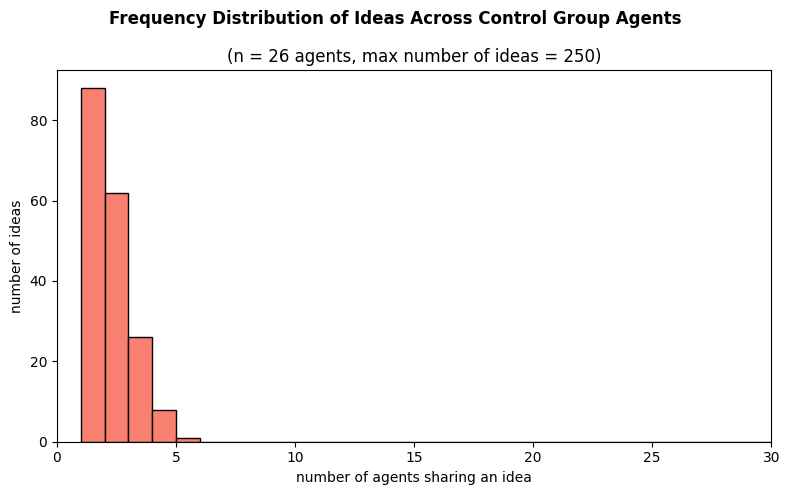

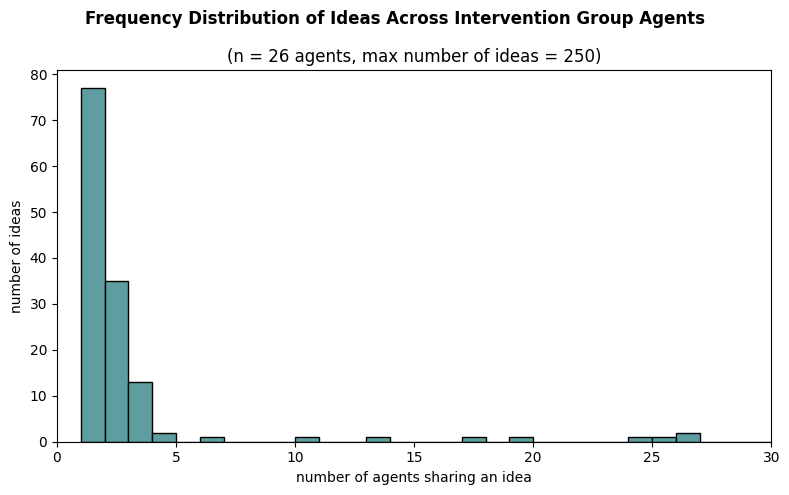

In [14]:
# All control group agents
control_agents = [a for a in agents if a.group == "control"]
# All intervention group agents
intervention_agents = [a for a in agents if a.group == "intervention"]

# Collect ideas for each group
control_final_ideas = []
for a in control_agents:
    control_final_ideas.extend(list(a.memory)) # Ensure memory is iterable if it's a set

intervention_final_ideas = []
for a in intervention_agents:
    intervention_final_ideas.extend(list(a.memory))

for a in agents:
    final_ideas.extend(list(a.memory))

# Calculate idea frequencies for each group
idea_freq_total = Counter(final_ideas)
idea_freq_control = Counter(control_final_ideas)
idea_freq_intervention = Counter(intervention_final_ideas)

# Determine the maximum frequency across all groups for consistent binning
max_freq = 0
if idea_freq_total:
    max_freq = max(max_freq, max(idea_freq_total.values()))
if idea_freq_control:
    max_freq = max(max_freq, max(idea_freq_control.values()))
if idea_freq_intervention:
    max_freq = max(max_freq, max(idea_freq_intervention.values()))

bins_range = range(1, max_freq + 2)


# Plot for Control Group
plt.figure(figsize=(8, 5))
plt.hist(idea_freq_control.values(), bins=bins_range, edgecolor='black', color='salmon')
plt.suptitle(f"Frequency Distribution of Ideas Across Control Group Agents", fontweight='bold')
plt.title(f"(n = {len(control_agents)} agents, max number of ideas = 250)")
plt.xlabel("number of agents sharing an idea")
plt.ylabel("number of ideas")
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

# Plot for Intervention Group
plt.figure(figsize=(8, 5))
plt.hist(idea_freq_intervention.values(), bins=bins_range, edgecolor='black', color='cadetblue')
plt.suptitle(f"Frequency Distribution of Ideas Across Intervention Group Agents", fontweight='bold')
plt.title(f"(n = {len(intervention_agents)} agents, max number of ideas = 250)")
plt.xlabel("number of agents sharing an idea")
plt.ylabel("number of ideas")
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

Step 0: Initial Idea Generation
Total unique ideas after Step 0: 240
AI memory size after Step 0: 202
Step 1:
Intervention Homogenization (%): 48.80
Control Homogenization (%): 28.00
Intervention Group Unique Ideas: 128
Control Group Unique Ideas: 180
- - - - -
Step 2:
Intervention Homogenization (%): 46.80
Control Homogenization (%): 19.20
Intervention Group Unique Ideas: 133
Control Group Unique Ideas: 202
- - - - -
Step 3:
Intervention Homogenization (%): 47.20
Control Homogenization (%): 19.60
Intervention Group Unique Ideas: 132
Control Group Unique Ideas: 201
- - - - -
Step 4:
Intervention Homogenization (%): 45.20
Control Homogenization (%): 23.20
Intervention Group Unique Ideas: 137
Control Group Unique Ideas: 192
- - - - -
Step 5:
Intervention Homogenization (%): 51.60
Control Homogenization (%): 25.20
Intervention Group Unique Ideas: 121
Control Group Unique Ideas: 187
- - - - -
Step 6:
Intervention Homogenization (%): 46.00
Control Homogenization (%): 20.80
Intervention Grou

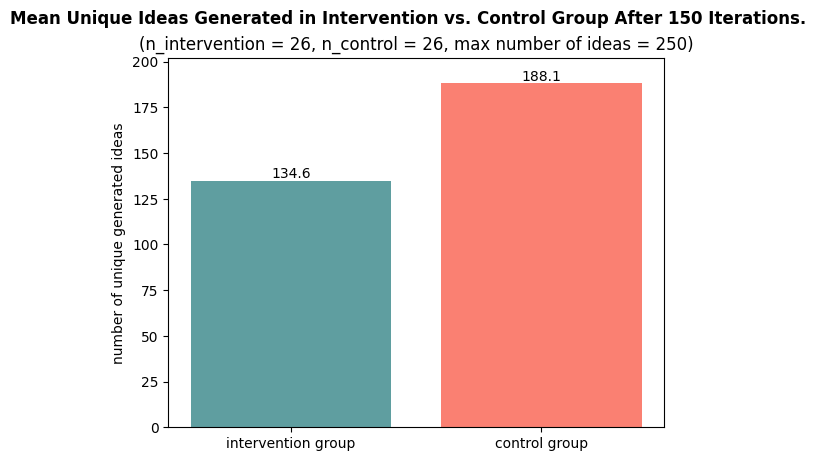

C:\Users\mbangerl\AppData\Local\Temp\ipykernel_11792\2742223397.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([data_intervention_group, data_control_group], labels=['intervention group', 'control group'],patch_artist=True, medianprops=dict(color='black'))


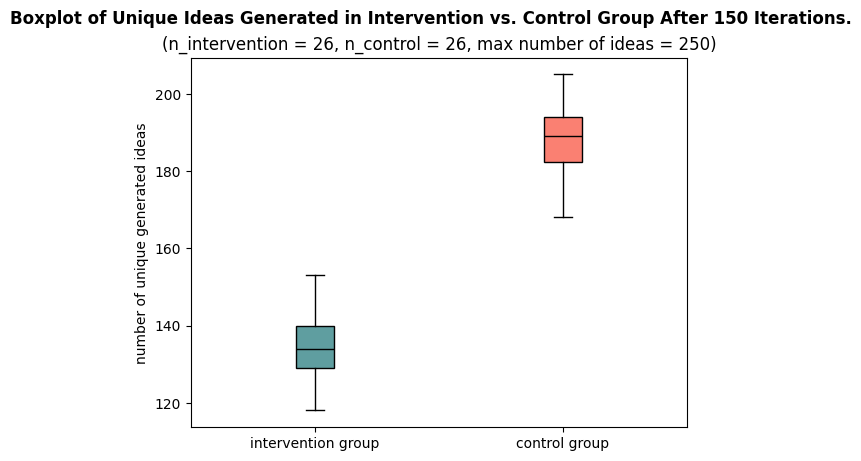

- - - - - - - - - - 
Mann-Whitney-U Test:
test statistic: 0.000, p: 0.000
The intervention group generated SIGNIFICANTLY FEWER creative ideas than the control group.


In [15]:
#loop model #takes about 40 seconds for me

intervention_unique_ideas_list = []
control_unique_ideas_list = []
iterations_number = 150

for iteration in range (iterations_number):
    model_i = HomogenizationModel(num_human_agents=52, total_idea_pool_size=250)
    while model_i.running:
        model_i.step()
    model_i_df = model_i.datacollector.get_model_vars_dataframe()

    intervention_unique_ideas_list.append(model_i_df["InterventionUniqueIdeas"].iloc[-1])
    control_unique_ideas_list.append(model_i_df["ControlUniqueIdeas"].iloc[-1])

statistical_analysis(intervention_unique_ideas_list, control_unique_ideas_list, iterations_number)
